In [1]:
import torch
# print (torch.cuda.current_device())
# print (torch.cuda.device(torch.cuda.current_device()))
print (torch.cuda.get_device_name(torch.cuda.current_device()))

Tesla T4


In [1]:
# from google.colab import drive
# # drive.flush_and_unmount()
# drive.mount('/content/drive',force_remount=True)

In [2]:
# install dependencies: (use cu100 because colab is on CUDA 10.0)
# !pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
# !pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print ('torch',torch.__version__)
print ('torchvision',torchvision.__version__)
!gcc --version
# opencv is pre-installed on colab

torch 1.4.0+cu100
torchvision 0.5.0+cu100
gcc (Ubuntu 7.4.0-1ubuntu1~18.04.1) 7.4.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [3]:
# !git clone https://github.com/facebookresearch/detectron2
# !git clone https://github.com/tangsanli5201/DeepPCB

In [4]:
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu100/index.html

# Mengmeng: cu100 means cuda v10.0? If have problem please install from source:
# https://github.com/facebookresearch/detectron2/blob/master/INSTALL.md

In [5]:
# You may need to restart your runtime prior to this, to let your installation take effect
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random
import os
#from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

In [6]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from matplotlib.pyplot import imshow
from PIL import Image
import IPython
def cv2_imshow(img):
    img = img[:,:,[2,1,0]]
    img = Image.fromarray(img)
    plt.figure(figsize=(20, 20))
    plt.imshow(img)
    plt.axis('off')
    plt.show()

In [7]:
from detectron2.data.datasets import register_coco_instances
from detectron2.data import DatasetCatalog
image_root_path = 'data/classifier/combined'
metadata_json_path = 'data/classifier/combined/metadata_coco_format.json'
detectron_output_dir = "data/classifier/output"

DatasetCatalog._REGISTERED.clear()
MetadataCatalog._NAME_TO_META.clear()
register_coco_instances("my_dataset", {}, metadata_json_path, image_root_path)

In [8]:
#check dataset
my_metadata = MetadataCatalog.get("my_dataset")
print(type(my_metadata))
my_dataset = DatasetCatalog.get('my_dataset')
for item in my_dataset:
  print (item)
  break
    
# TODO: Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.


<class 'detectron2.data.catalog.Metadata'>
WARNING [04/01 19:40:09 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/01 19:40:09 d2.data.datasets.coco]: Loaded 219 images in COCO format from data/classifier/combined/metadata_coco_format.json
{'file_name': '/home/ubuntu/git-clones/AutoCheckout-CMU-F4/data/classifier/combined/022000135377/022000135377_100.jpg', 'height': 720, 'width': 1280, 'image_id': '022000135377_100', 'annotations': [{'iscrowd': 0, 'bbox': [677.0, 241.0, 346.0, 356.0], 'category_id': 17, 'bbox_mode': <BoxMode.XYWH_ABS: 1>}]}


In [9]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.OUTPUT_DIR = detectron_output_dir
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/faster_rcnn_R_50_FPN_3x/137849458/model_final_280758.pkl"  # Let training initialize from model zoo
cfg.SOLVER.CHECKPOINT_PERIOD = 1000 # checkpoint every 10min
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.02  # pick a good LR
cfg.SOLVER.MAX_ITER = 500    # 300 iterations seems good enough for this toy dataset; you may need to train longer for a practical dataset
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512   # faster, and good enough for this toy dataset (default: 512)
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 18 

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=True)
trainer.train()
#It will train about 20 minutes in colab.

[04/01 19:40:15 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

WARNING [04/01 19:40:15 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/01 19:40:15 d2.data.datasets.coco]: Loaded 219 images in COCO format from data/classifier/combined/metadata_coco_format.json
[04/01 19:40:15 d2.data.build]: Removed 0 images with no usable annotations. 219 images left.
[04/01 19:40:15 d2.data.build]: Distribution of instances among all 18 categories:
|   category   | #instances   | category     | #instances   | category     | #instances   |
|:------------:|:-------------|:-------------|:-------------|:-------------|:-------------|
| 041419420058 | 18           | 040000513056 | 12           | 042238323643 | 9            |
| 835144008984 | 13           | 634418523501 | 12           | 084114032607 | 12           |
| 026200471594 | 12           | 084114033338 | 14           | 079200168490 | 11           |
| 041364087320 | 13           | 078907420108 | 12           | 835144009066 | 11           |
| 02

In [10]:
# ! pwd
# ! ls "drive/My Drive/Colab Notebooks/combined_219_images/data/classifier/combined/041364087320/041364087320_700.jpg"

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.1   # set the testing threshold for this model
cfg.DATASETS.TEST = ("my_dataset", )
predictor = DefaultPredictor(cfg)

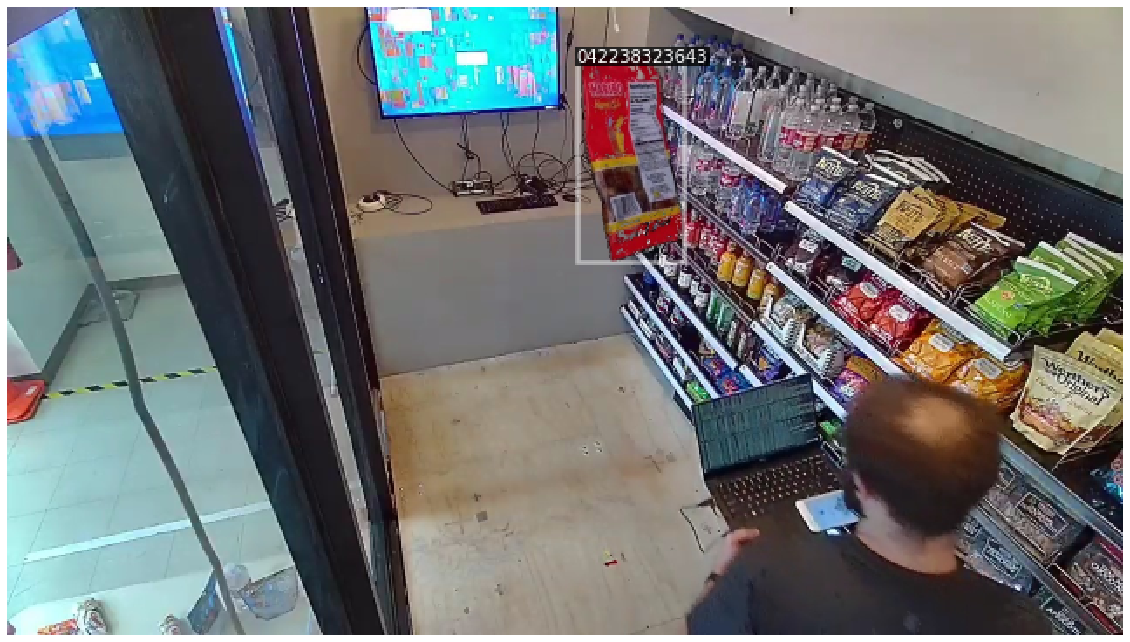

In [12]:
from detectron2.utils.visualizer import ColorMode
import random

for d in random.sample(my_dataset, 1):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [13]:
product_barcodes = ['634418523501', '024100114238', '070462098617', '034000996629', '835144008984', '084114032607', '634418523488', '078907420108', '026200471594', '872181000069', '041419420058', '835144009066', '042238323643', '040000513056', '041364087320', '084114033338', '022000135377', '079200168490']
product_names = ['Albanese, Mini Gummi Worms', 'CheezIt Double Cheese', 'Sour Patch Kids Peg', 'Hershey Kit Kat Mini Pouch', 'Peach Rings', 'Kettle Krinkle Cut Salt and Fresh Ground Pepper Potato Chips', 'Albanese, 12 Flavor Gummi Bears', 'El Sabroso Blazing Hot Cheetos', 'Andy Capps Hot Fry Bag', 'Milk Choclate Pretzel', 'Baked Snacks Pretzel', 'Chili Mango', 'Happy-cola Gummi Candy', "M&M's Candy Peanut", 'Bites Candy', 'Kettle Chips Sea Salt & Vinegar', 'Starburst, Minis FaveREDS Unwrapped Fruit Chews Candy', 'SweeTarts Rope Bites']
product_thumbnails = ['https://cdn.shopify.com/s/files/1/0083/0704/8545/products/12-flavor-mini-gummi-worms_22_faadbaa5-4448-483d-9fc5-0eabfaab3e36_128x.jpg?v=1565210205', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/prod_img-6831670_snapd-double-cheddar_128x.png?v=1565210227', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/tmg-article_tall.jpg?v=1565210313', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/prod_10331_969_medium_b9a6fc1d-8ca9-4c83-9ade-ffcc8f52ec9a_128x.jpg?v=1565210297', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/gummy-peach-rings_128x.jpg?v=1565210404', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/GUEST_fb4c6822-b3f3-4a5e-b518-c43fb838a061_128x.jpg?v=1565210320', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/71xDYoGWf4L._SL1500_8e3d4a2d-4cf4-4b07-bd87-d51da0145f7d_128x.jpg?v=1565210203', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/243090-1_3be6caea-96bc-4bcb-aa2d-b873a3648e94_128x.png?v=1565210263', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/71peyTy8EtL._SY679_44871093-2397-4195-8116-d4f1e5e8831f_128x.jpg?v=1565210210', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/81uaUnvcPBL._SY355_f393d9c4-b77b-4129-b201-4a5a17aadcdc_128x.jpg?v=1565210272', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/P1000628_128x.jpg?v=1565210246', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/IMG_3706_d49c9fde-6362-4f24-9115-5fc29a552d9f_128x.jpg?v=1565210398', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/91ljaN-fLwL._SY450_753391e5-5392-4878-9ef6-2ed1d4be95d3_128x.jpg?v=1565210288', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/prod_17842684915_19ee4535-50bd-4c5a-9094-9c22ebc61263_128x.jpg?v=1565210330', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/450_25b69ae3-e0e6-403f-b1c8-211c154257ef_128x.jpg?v=1565210414', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/0084114108142_a1c1_0600_f6c7c0b7-9e56-4831-b0aa-d30347afef57_128x.png?v=1565210322', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/71-wnSPKeJL._SL1200_4155c1f2-b688-4706-afd2-fe88d0ebf6ed.jpg?v=1565210411', 'https://cdn.shopify.com/s/files/1/0083/0704/8545/products/81q81-uD8eL._SY679_12162139-8b05-41ac-9c5b-00e65985824d_128x.jpg?v=1565210342']
products = {}
for i in range(18):
  products[product_barcodes[i]] = {
      'name': product_names[i],
      'barcode': product_barcodes[i],
      'thumbnail': product_thumbnails[i]
  }

29% 835144008984 Peach Rings: https://cdn.shopify.com/s/files/1/0083/0704/8545/products/gummy-peach-rings_128x.jpg?v=1565210404
26% 634418523501 Albanese, Mini Gummi Worms: https://cdn.shopify.com/s/files/1/0083/0704/8545/products/12-flavor-mini-gummi-worms_22_faadbaa5-4448-483d-9fc5-0eabfaab3e36_128x.jpg?v=1565210205
15% 084114033338 Kettle Chips Sea Salt & Vinegar: https://cdn.shopify.com/s/files/1/0083/0704/8545/products/0084114108142_a1c1_0600_f6c7c0b7-9e56-4831-b0aa-d30347afef57_128x.png?v=1565210322
12% 078907420108 El Sabroso Blazing Hot Cheetos: https://cdn.shopify.com/s/files/1/0083/0704/8545/products/243090-1_3be6caea-96bc-4bcb-aa2d-b873a3648e94_128x.png?v=1565210263


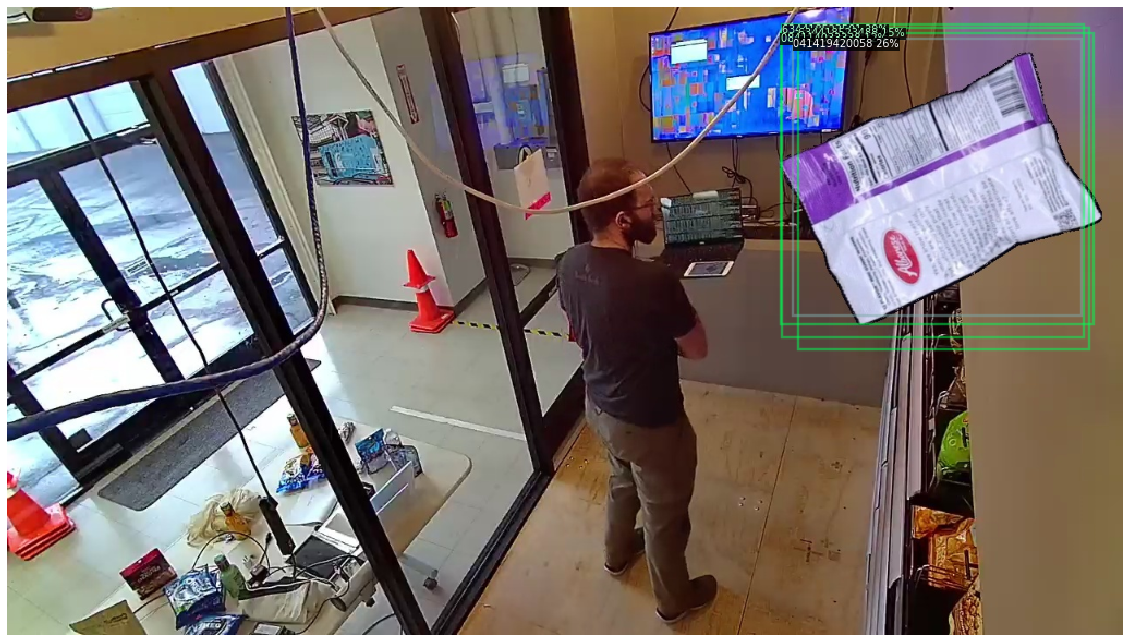

20% 835144008984 Peach Rings: https://cdn.shopify.com/s/files/1/0083/0704/8545/products/gummy-peach-rings_128x.jpg?v=1565210404
14% 084114033338 Kettle Chips Sea Salt & Vinegar: https://cdn.shopify.com/s/files/1/0083/0704/8545/products/0084114108142_a1c1_0600_f6c7c0b7-9e56-4831-b0aa-d30347afef57_128x.png?v=1565210322
10% 041419420058 Baked Snacks Pretzel: https://cdn.shopify.com/s/files/1/0083/0704/8545/products/P1000628_128x.jpg?v=1565210246


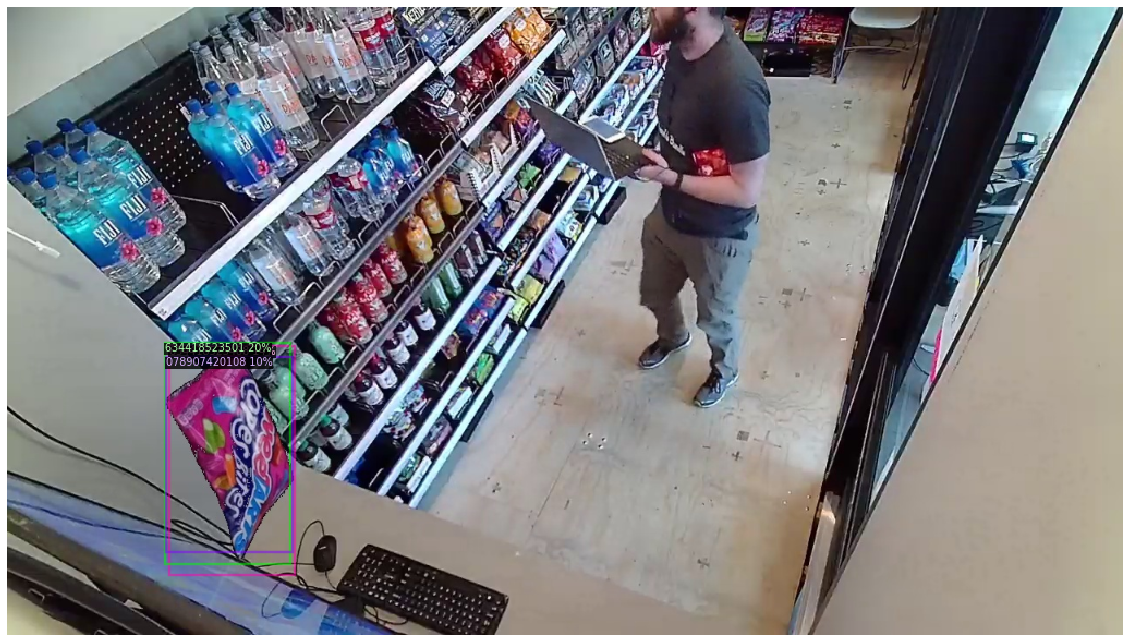

15% 835144008984 Peach Rings: https://cdn.shopify.com/s/files/1/0083/0704/8545/products/gummy-peach-rings_128x.jpg?v=1565210404
12% 041419420058 Baked Snacks Pretzel: https://cdn.shopify.com/s/files/1/0083/0704/8545/products/P1000628_128x.jpg?v=1565210246
11% 084114033338 Kettle Chips Sea Salt & Vinegar: https://cdn.shopify.com/s/files/1/0083/0704/8545/products/0084114108142_a1c1_0600_f6c7c0b7-9e56-4831-b0aa-d30347afef57_128x.png?v=1565210322


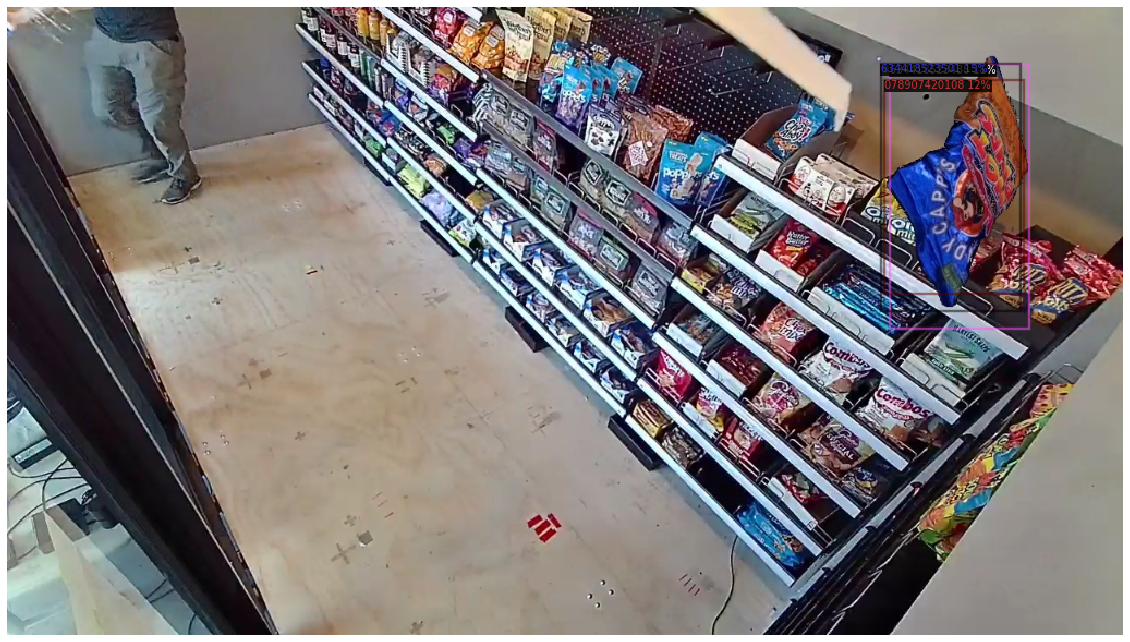

In [14]:
for d in random.sample(my_dataset, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    # print (outputs)
    v = Visualizer(im,
                   metadata=my_metadata, 
                   scale=0.8,
                   instance_mode =  ColorMode.IMAGE
        )
                   # remove the colors of unsegmented pixels
    for i in range(len(outputs['instances'].pred_classes)):
      pred_barcode = product_barcodes[outputs['instances'].pred_classes[i]]
      score = outputs['instances'].scores[i]
      pred_product = products[pred_barcode]
      print("%.0f%% %s %s: %s" % (100 * score.to("cpu").numpy(), pred_barcode, pred_product['name'], pred_product['thumbnail']))
    # print(outputs["instances"].pred_boxes)

    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image())